In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

In [4]:
def softmax_prob_forloop(W, b, inputs):
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    dim, datalen = np.shape(inputs) # how many dimensions, points
    c = len(b) # number of classes, C, each class has a bias
    score = np.zeros((c, datalen))
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = b[cj] 
            for dk in range(dim):
                score[ci, lj] += W[ci, dk]*inputs[dk, lj]
    maxes = np.zeros(datalen)
    for lj in range(datalen):
        maxes = np.max(score[:, lj])
    for ci in range(c):
        for lj in range(datalen):
            score[ci, lj] = score[ci, lj] - maxes[lj]
    # subtract off the largest score from the bias of each class
    # This is for stability to underflow/overflow when exponentiating
    expscore = np.exp(score)
    norm_factor = np.diag(1/np.sum(expscore, axis=0))
    return np.dot(expscore, norm_factor).T
    

In [5]:
def softmax_prob1(W, b, inputs):
    # inputs is dim-by-datalen
    # b is C-dimensional vector W is (C-by-dim)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1]
    c = len(b)
    linear_part = jnp.dot(W, inputs) #
    large = jnp.max(linear_part, axis=0)
    bias_offset = jnp.dot(jnp.diag(b),jnp.ones((c, datalen)))
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large)) 
    expscore = jnp.exp(linear_part + bias_offset - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [8]:
def softmax_prob(W, inputs):
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1]
    c = len(W)# number of classes, C, each class has a bias
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    score = jnp.dot(W,inputs)
    large = jnp.max(score, axis=0)
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large))
    expscore = jnp.exp(score - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [9]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [10]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [15]:
Wb = jnp.array([[-3., 1.3, 2.0, -1.0], [-6., -2., -3., 1.5], [1., 2.0, 2.0, 2.5], [3., 4.0, 4.0, -2.5]])

inputs = jnp.array([[0.52, 1.12, 0.77],
    [3.82, -6.11, 3.15],
    [0.88, -1.08, 0.15],
    [0.52, 0.06, -1.30],
    [0.74, -2.49, 1.39],
    [0.14, -0.43, -1.69]]).T 

targets = jnp.array([0, 1, 3, 2, 1, 2])

In [17]:
key = random.PRNGKey(0)
key, W_key= random.split(key, 2)
[classes, dim] = 4, 3
Winit = random.normal(W_key, (classes, dim+1))
print(Winit)

[[ 0.20820066 -1.0580499  -0.29374585 -0.44117254]
 [ 0.2366984  -0.03426386 -1.0025561   1.1560111 ]
 [-0.5381381  -0.48968917  0.24939033 -1.4128867 ]
 [ 1.8543106   0.22756499  0.49751544 -2.089685  ]]


In [18]:
def grad_descent(Wb, inputs, targets, num_classes, lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    return W1, Whist, losshist

In [19]:
W2, Whist, losshist = grad_descent(Winit, inputs, targets, 4, 0.75, 200)

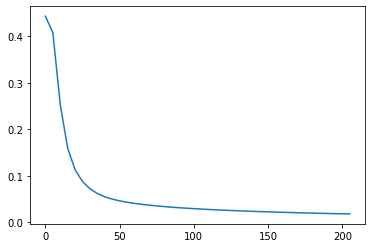

In [20]:
plt.plot([5*i for i in range(len(losshist))], losshist)